In [85]:
using Pkg
Pkg.add("NonlinearSolve")


   Resolving package versions...
  No Changes to `~/.julia/environments/v1.10/Project.toml`
  No Changes to `~/.julia/environments/v1.10/Manifest.toml`


In [ ]:
using NLsolve, Distributed

# Add worker processes for multiprocessing (replace '20' with desired number of cores, or use Sys.CPU_threads() )
# The Julia session must be started with multiple processes or threads:
# For processes (like this example, separate memory spaces):
# julia -p 20 script.jl 
# For threads (shared memory):
# julia --threads 20 script.jl 
# Using Distributed.addprocs(20) at runtime is also an option.
# We'll use pmap later for distributed processing over 'chi_list' (or another outer loop).

vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
const chi0 = 1e-8 # Initial chi value for annealing
const annealing_steps = 100 # Number of steps to anneal chi
const P_values = # ... define your list of P values
const chi_list = # ... define your list of final chi values
const prev_sol_initial = fill(0.1, vars_len) # Initial guess for the first chi and P

@everywhere begin
    # Define all necessary constants and functions here
    const d = 3.0
    const kappa = 1.0
    const delta = 1.0
    const epsilon = 0.003
    const n = 1000
    const b = 4/(3 * π)
    const P_values = d .^ range(0.1, 2.0, length=50)
    # ... other necessary definitions, including functions!
end

# ---------------------------
# SYSTEM OF EQUATIONS (unchanged)
# ---------------------------
function equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    # ... (rest of the equations function remains the same, but now takes parameters)
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end

# ---------------------------
# HELPER FUNCTIONS (unchanged, assuming constants are globally available or passed)
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

function compute_lK_ratio(sol, P, dval, kappa)
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/dval
    TrSigma = lWT + lWP*(dval-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# CORE SOLUTION FUNCTION with CHI ANNEALING
# ---------------------------

# Solves for a single final_chi value over all P_values, using chi annealing.
# Assumes d, kappa, delta, epsilon, n, b are available or passed.
function solve_with_annealing(final_chi, P_values, chi0, annealing_steps, initial_guess, 
                                d, kappa, delta, epsilon, n, b)
    
    # 1. Chi Annealing Steps (log-spaced)
    chi_anneal_list = exp.(range(log(chi0), log(final_chi), length=annealing_steps))
    
    # Initialize continuation: Start at chi0 solution, then continue with P_values
    prev_sol = initial_guess # Use the provided initial guess for the first chi and P
    
    # Store results for this final_chi
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    println("Starting annealing for final chi = $final_chi...")
    
    # 2. Anneal chi up to final_chi
    for chi in chi_anneal_list
        # Continue from the previous P solution's result, as chi changes slowly
        new_prev_sol = prev_sol
        
        # We solve for *all* P-values for this intermediate chi
        for (i, P) in enumerate(P_values)
            # Define the equation function for the current P and chi
            f!(F,x) = equations!(F, x, P, chi, d, kappa, delta, epsilon, n, b)
            
            try
                sol = nlsolve(f!, new_prev_sol).zero
                
                # Only store if it's the final chi in the annealing list
                if chi == final_chi
                    sols[i] = is_physical(sol) ? sol : nothing
                end
                
                new_prev_sol = sol  # Continuation for P (within the same chi step)
            catch
                # If a solve fails, stick with the previous solution for continuation
                if chi == final_chi
                     sols[i] = nothing
                end
            end
        end
        # The final solution from the last P is the starting guess for the next chi
        prev_sol = new_prev_sol
    end

    return (final_chi, sols)
end

# ---------------------------
# MULTIPROCESSING
# ---------------------------

# Use 'pmap' (Parallel Map) to distribute the computation over multiple processes (cores).
# Assumes 'd', 'kappa', 'delta', 'epsilon', 'n', 'b' are defined globally or passed to the scope.
# The 'chi_list' is the set of maximum chi values to be solved.
# Each worker process will execute 'solve_with_annealing' for one final_chi value.

println("Starting parallel computation on $(nworkers()) workers...")

# Note: The global constants (d, kappa, delta, epsilon, n, b) must be available to all workers.
# This often requires preceding the code with:


# pmap distributes the function call over the elements of chi_list
parallel_results = pmap(chi -> solve_with_annealing(chi, P_values, chi0, annealing_steps, prev_sol_initial, d, kappa, delta, epsilon, n, b), chi_list)

# Re-package the results into the desired dictionary format
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}(pair[1] => pair[2] for pair in parallel_results)


# ---------------------------
# POSTPROCESS (unchanged)
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i], d, kappa) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

   Resolving package versions...
package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environ

is_physical (generic function with 1 method)

In [7]:

# ---------------------------
# VECTORIZED SOLVER
# ---------------------------


import Pkg; Pkg.add("NLsolve")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")

using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

    Updating registry at `~/.julia/registries/General.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`
   Resolving package versions...
     Project No packages added to or removed from `~/.julia/environments/v1.12/Project.toml`
    Manifest No packages added to or removed from `~/.julia/environments/v1.12/Manifest.toml`


In [80]:

# ---------------------------
# PARAMETERS
# ---------------------------
n = 200
kappa = 1.0
d = 65
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

alphas = range(0.1, stop=2.0, length=500)
P_values =  d .^ collect(alphas)
chi_list = [10.00, n^0.5, n]


3-element Vector{Float64}:
  10.0
  14.142135623730951
 200.0

In [81]:

vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end


compute_lK_ratio(sol, P, dval=d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for chi in chi_list
    println("Solving for chi = $chi ...")
    prev_sol = fill(0.1, vars_len)
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for (i,P) in enumerate(P_values)
        f!(F,x) = equations!(F,x,P,chi)
        try
            sol = nlsolve(f!, prev_sol).zero
            sols[i] = is_physical(sol) ? sol : nothing
            prev_sol = sol  # continuation
        catch
            sols[i] = nothing
        end
    end
    results[chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)


Solving for chi = 10.0 ...
Solving for chi = 14.142135623730951 ...
Solving for chi = 200.0 ...


Dict{Float64, Vector{Tuple{Float64, Float64}}} with 3 entries:
  200.0   => [(0.00705554, 1.04402e-5), (0.0173745, 2.0798e-5), (0.0128923, 1.6…
  10.0    => [(0.00970504, 0.00277001), (0.00886023, 0.000727677), (0.0137305, …
  14.1421 => [(0.0104396, 0.00323348), (0.0130632, 0.00246125), (0.0123219, 0.0…

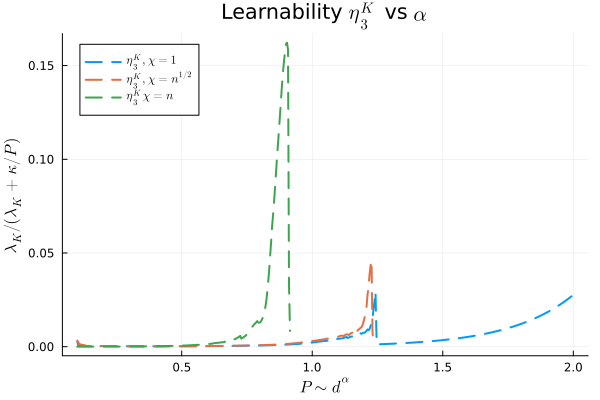

In [82]:

plot(alphas, [r[2] for r in lK_ratio[10]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")


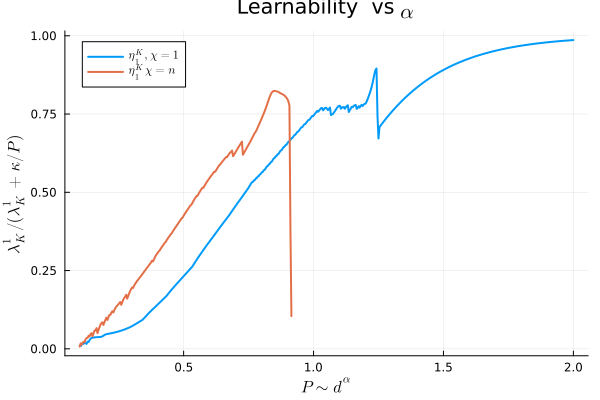

ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error
ERROR: syntax error


In [83]:
plot(alphas, [r[1] for r in lK_ratio[10]], label=L"\eta^K_1,\chi=1", lw=2)
# plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L" \eta_ " * " vs " *L" \alpha ")

In [32]:
n

600

In [33]:
7.62e-3

0.00762

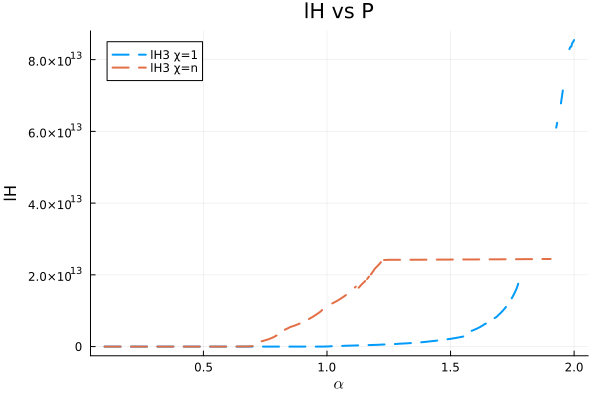

In [78]:
# ---------------------------
# PLOTTING
# ---------------------------
# plot(alphas, (lH1_series[1]), label="lH1 χ=1", lw=2)
# plot!(alphas, (lH1_series[n]), label="lH1 χ=n", lw=2)
plot(alphas[1:500], (lH3_series[10][1:500]), label="lH3 χ=1", lw=2, ls=:dash)
plot!(alphas, (lH3_series[n]), label="lH3 χ=n", lw=2, ls=:dash)
xlabel!(L"\alpha"); ylabel!("lH"); title!("lH vs P")


In [35]:
mask = (d.^alphas .>= 80) .& (d.^alphas .<= 90)
lH3_series[1][mask]

8-element Vector{Float64}:
 3.104518473638808e-5
 3.104509495917238e-5
 3.104500396756256e-5
 3.104491176029385e-5
 3.1044818336590416e-5
 3.104472369617533e-5
 3.104462783927998e-5
 3.104453076665328e-5

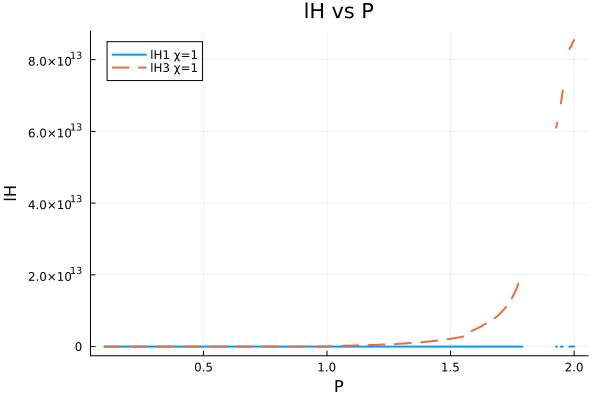

In [79]:
plot(alphas, (lH1_series[10]), label="lH1 χ=1", lw=2)
plot!(alphas, (lH3_series[10]), label="lH3 χ=1", lw=2, ls=:dash)
xlabel!("P"); ylabel!("lH"); title!("lH vs P")

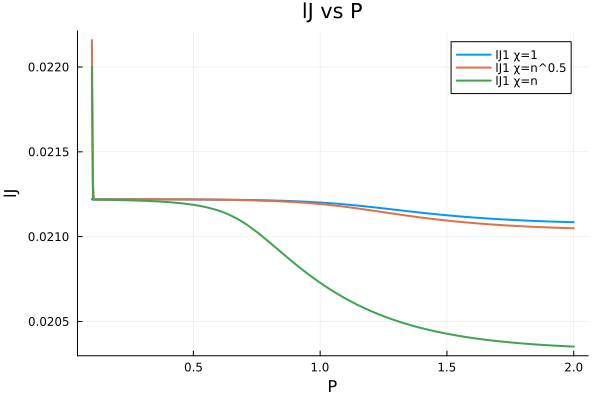

In [57]:

plot(alphas, (lJ1_series[10]), label="lJ1 χ=1", lw=2)
plot!(alphas, (lJ1_series[n^0.5]), label="lJ1 χ=n^0.5", lw=2)

plot!(alphas, (lJ1_series[n]), label="lJ1 χ=n", lw=2)
xlabel!("P"); ylabel!("lJ"); title!("lJ vs P")


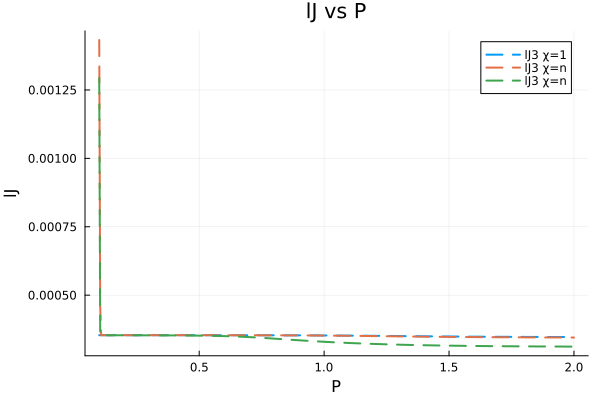

In [59]:

plot(alphas, (lJ3_series[10]), label="lJ3 χ=1", lw=2, ls=:dash)
plot!(alphas, (lJ3_series[n^0.5]), label="lJ3 χ=n", lw=2, ls=:dash)
plot!(alphas, (lJ3_series[n]), label="lJ3 χ=n", lw=2, ls=:dash)
xlabel!("P"); ylabel!("lJ"); title!("lJ vs P")


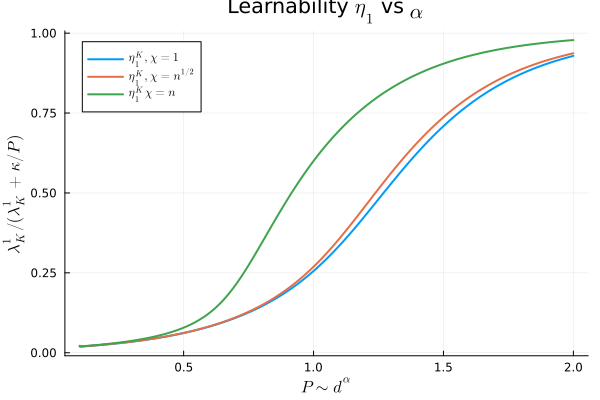

In [61]:
plot(alphas, [r[1] for r in lK_ratio[10]], label=L"\eta^K_1,\chi=1", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n^0.5]], label=L"\eta^K_1, \chi=n^{1/2}", lw=2)
plot!(alphas, [r[1] for r in lK_ratio[n]], label=L"\eta^K_1 \chi=n", lw=2)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K^1/(\lambda_K^1 + \kappa/P)"); 
title!("Learnability " * L" \eta_1 " * " vs " *L" \alpha ")

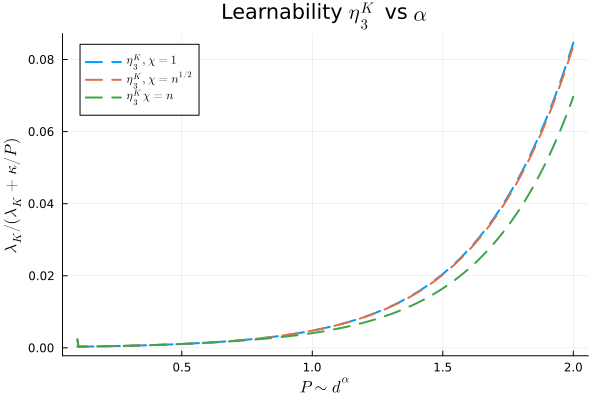

In [62]:
plot(alphas, [r[2] for r in lK_ratio[10]], label=L"\eta^K_3,\chi=1", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n^0.5]], label=L"\eta^K_3, \chi=n^{1/2}", lw=2, ls=:dash)
plot!(alphas, [r[2] for r in lK_ratio[n]], label=L"\eta^K_3 \chi=n", lw=2, ls=:dash)
xlabel!(L"$P \sim d^\alpha$"); ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)"); 
title!("Learnability " * L" \eta^K_3 " * " vs " *L" \alpha ")

Solving for n = 10.0 ...
Solving for n = 100.0 ...
Solving for n = 1000.0 ...
Solving for n = 10000.0 ...
Solving for n = 100000.0 ...
Solving for n = 1.0e6 ...
Solving for n = 1.0e7 ...


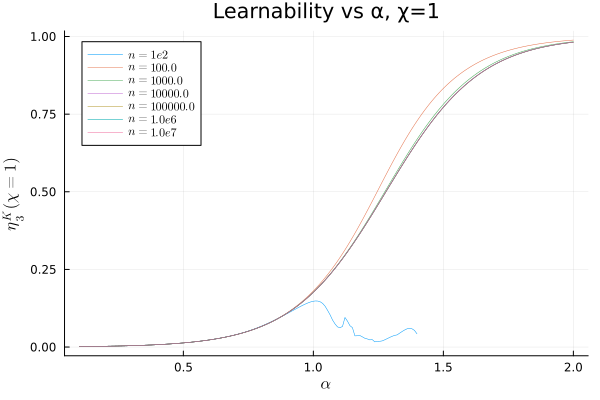

In [ ]:
using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n_list = [10, 1e2, 1e3, 1e4, 1e5, 1e6, 1e7]
kappa = 1.0
d = 250
b = 4 / (3 * π)
epsilon = 0.3
delta = 1.0

alphas = range(0.1, stop=2.0, length=200)  # fewer points for speed
P_values_list = [d .^ collect(alphas) for _ in n_list]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

chi_dict = Dict("chi1"=>1.0, "chin"=>nothing)  # chin will be set per n

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, n)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

compute_lK_ratio(sol, P, n) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end


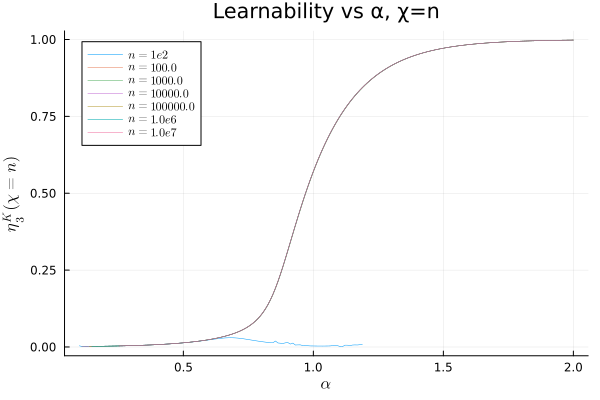

In [ ]:

plot(alphas, lK3_chin[1], label=L"n=1e2", lw=0.5)
for i in 2:length(n_list)
    plot!(alphas, lK3_chin[i], label=L"n="*L"$"*string(n_list[i])*L"$", lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n")


In [ ]:

# ---------------------------
# SOLVE AND COLLECT RESULTS
# ---------------------------
results_dict = Dict()

for (ni, nval) in enumerate(n_list)
    println("Solving for n = $nval ...")
    P_values = P_values_list[ni]
    chi_dict["chin"] = nval  # chi=n
    results_chi = Dict()
    for (chi_name, chi_val) in chi_dict
        prev_sol = fill(0.1, vars_len)
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        for (i,P) in enumerate(P_values)
            f!(F,x) = equations!(F,x,P,chi_val,nval)
            try
                sol = nlsolve(f!, prev_sol).zero
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            catch
                sols[i] = nothing
            end
        end
        results_chi[chi_name] = sols
    end
    results_dict[nval] = results_chi
end

# ---------------------------
# EXTRACT lK3 RATIOS FOR PLOTTING
# ---------------------------
function extract_lK3(results_dict, n_list, chi_name)
    lK3_ratios = []
    for nval in n_list
        sols = results_dict[nval][chi_name]
        P_values = d .^ collect(alphas)
        push!(lK3_ratios, [compute_lK_ratio(sol,P,nval)[2] for (sol,P) in zip(sols,P_values)])
    end
    return lK3_ratios
end

lK3_chi1 = extract_lK3(results_dict,n_list,"chi1")
lK3_chin = extract_lK3(results_dict,n_list,"chin")

# ---------------------------
# PLOTTING
# ---------------------------
plot(alphas, lK3_chi1[1], label=L"n=1e2", lw=0.5)
for i in 2:length(n_list)
    plot!(alphas, lK3_chi1[i], label=L"n="*L"$"*string(n_list[i])*L"$", lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=1)"); title!("Learnability vs α, χ=1")

In [ ]:
using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3            # fixed number of samples
d_list = [50, 100, 250, 500, 1e4, 1e6]  # dimensions to sweep
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

alphas = range(0.1, stop=2.0, length=10000)  # P = d^α
vars_len = 8

chi_dict = Dict("chi1"=>1.0, "chin"=>n)  # chi = 1 or chi = n

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, n, d)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

compute_lK_ratio(sol, P, n, d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (d + delta * b * lV1 / n)
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# SOLVE OVER d
# ---------------------------
results_dict = Dict()

for dval in d_list
    println("Solving for d = $dval ...")
    P_values = dval .^ collect(alphas)
    results_chi = Dict()
    for (chi_name, chi_val) in chi_dict
        prev_sol = fill(0.1, vars_len)
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        for (i,P) in enumerate(P_values)
            f!(F,x) = equations!(F,x,P,chi_val,n,dval)
            try
                sol = nlsolve(f!, prev_sol).zero
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            catch
                sols[i] = nothing
            end
        end
        results_chi[chi_name] = sols
    end
    results_dict[dval] = results_chi
end

# ---------------------------
# EXTRACT lK3 RATIOS FOR PLOTTING
# ---------------------------
function extract_lK3(results_dict, d_list, chi_name)
    lK3_ratios = []
    for dval in d_list
        sols = results_dict[dval][chi_name]
        P_values = dval .^ collect(alphas)
        push!(lK3_ratios, [compute_lK_ratio(sol,P,n,dval)[2] for (sol,P) in zip(sols,P_values)])
    end
    return lK3_ratios
end

lK3_chi1 = extract_lK3(results_dict,d_list,"chi1")
lK3_chin = extract_lK3(results_dict,d_list,"chin")


Solving for d = 50.0 ...
Solving for d = 100.0 ...
Solving for d = 250.0 ...
Solving for d = 500.0 ...
Solving for d = 10000.0 ...
Solving for d = 1.0e6 ...


6-element Vector{Any}:
 [0.006170729624416277, 0.006175289626196742, 0.006179852976090776, 0.006184419676524235, 0.006188989729924688, 0.006193563138721389, 0.00619813990534533, 0.006202720032229204, 0.006207303521807415, 0.006211890376516087  …  0.9169023594551405, 0.9169601582903253, 0.9170179198292009, 0.9170756440915729, 0.9171333310972424, 0.9171909808660066, 0.9172485934176582, 0.9173061687719863, 0.917363706948776, 0.9174212079678074]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.9626854703007998, 0.9627173503737235, 0.9627492038817931, 0.9627810308459536, 0.962812831287135, 0.962844605226254, 0.9628763526842122, 0.9629080736818971, 0.9629397682401818, 0.9629714363799251]
 [NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN, NaN  …  0.9880847913103217, 0.9880972207898787, 0.9881096373725421, 0.9881220410715471, 0.9881344319001161, 0.9881468098714581, 0.9881591749987687, 0.9881715272952307, 0.9881838667740134, 0.9881961934482727]
 [NaN, NaN, NaN, 0.0008009911604674212, 0.0008

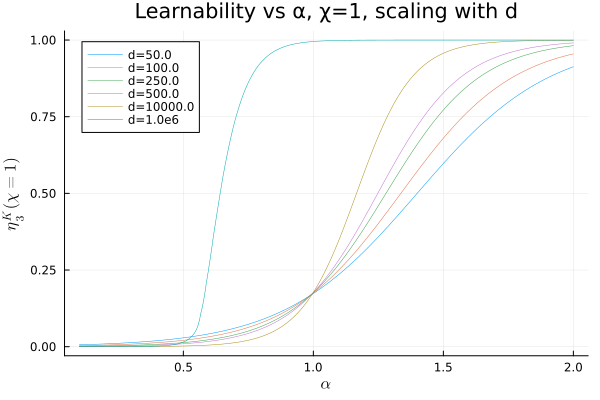

In [ ]:

# ---------------------------
# PLOTTING
# ---------------------------
plot(alphas, lK3_chi1[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK3_chi1[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=1)"); title!("Learnability vs α, χ=1, scaling with d")

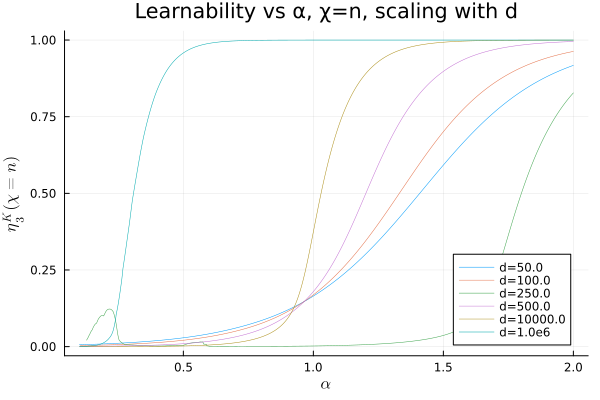

In [ ]:

plot(alphas, lK3_chin[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK3_chin[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n, scaling with d")


In [ ]:

plot(alphas, lK1_chin[1], label=LaTeXString("d=$(d_list[1])"), lw=0.5)
for i in 2:length(d_list)
    plot!(alphas, lK1_chin[i], label=LaTeXString("d=$(d_list[i])"), lw=0.5)
end
xlabel!(L"\alpha"); ylabel!(L"\eta^K_3 (\chi=n)"); title!("Learnability vs α, χ=n, scaling with d")


LoadError: UndefVarError: `lK1_chin` not defined

In [ ]:
# ---------------------------
# PARAMETERS
# ---------------------------
d_range = 10:10:4000  # d values from 10 to 4000 with step size 10
results_d_range = Dict()
chi_dict = Dict("chi1"=>1.0, "chin"=>n)  # chi = 1 or chi = n

# ---------------------------
# SOLVE OVER d RANGE
# ---------------------------
for dval in d_range
    println("Solving for d = $dval ...")
    P_values = dval .^ collect(alphas)
    results_chi = Dict()
    for (chi_name, chi_val) in chi_dict
        prev_sol = fill(0.1, vars_len)
        sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
        for (i, P) in enumerate(P_values)
            f!(F, x) = equations!(F, x, P, chi_val, n, dval)
            try
                sol = nlsolve(f!, prev_sol).zero
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            catch
                sols[i] = nothing
            end
        end
        results_chi[chi_name] = sols
    end
    results_d_range[dval] = results_chi
end

Solving for d = 10 ...
Solving for d = 20 ...
Solving for d = 30 ...
Solving for d = 40 ...
Solving for d = 50 ...
Solving for d = 60 ...
Solving for d = 70 ...
Solving for d = 80 ...
Solving for d = 90 ...
Solving for d = 100 ...
Solving for d = 110 ...
Solving for d = 120 ...
Solving for d = 130 ...
Solving for d = 140 ...
Solving for d = 150 ...
Solving for d = 160 ...
Solving for d = 170 ...
Solving for d = 180 ...
Solving for d = 190 ...
Solving for d = 200 ...
Solving for d = 210 ...
Solving for d = 220 ...
Solving for d = 230 ...
Solving for d = 240 ...
Solving for d = 250 ...
Solving for d = 260 ...
Solving for d = 270 ...
Solving for d = 280 ...
Solving for d = 290 ...
Solving for d = 300 ...
Solving for d = 310 ...
Solving for d = 320 ...
Solving for d = 330 ...
Solving for d = 340 ...
Solving for d = 350 ...
Solving for d = 360 ...
Solving for d = 370 ...
Solving for d = 380 ...
Solving for d = 390 ...
Solving for d = 400 ...
Solving for d = 410 ...
Solving for d = 420 ...
S

In [ ]:
results_d_range

Dict{Any, Any} with 400 entries:
  2050 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  3490 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  60   => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  220  => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  1900 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  1010 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  2350 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  3620 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  2780 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  3830 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  3710 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, nothi…
  2070 => Dict{Any, Any}("chin"=>Union{Nothing, Vector{Float64}}[nothing, no

In [ ]:
using Pkg
Pkg.add("NLsolve")
Pkg.add("Plots")
Pkg.add("LaTeXStrings")
Pkg.add("LinearAlgebra")

using NLsolve
using LinearAlgebra
using Plots
using LaTeXStrings


Solving for chi = 1.0 ...


Solving for chi = 31.622776601683793 ...
Solving for chi = 1000.0 ...


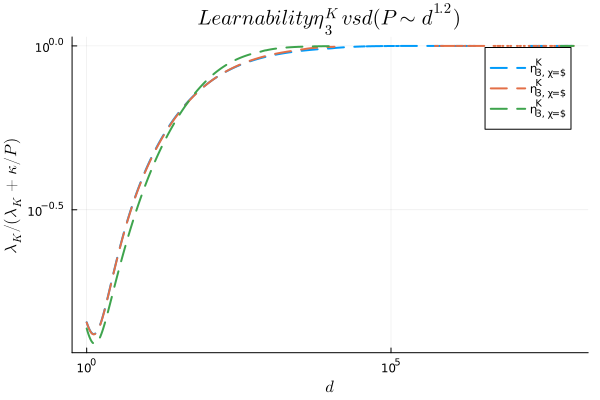

In [26]:
using NLsolve
using Statistics
using Plots
using LaTeXStrings

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3
kappa = 1.0
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

d_values = 10 .^ range(log10(1), log10(1e8), length=500)  # Logspaced d from 1 to 1e8
P_values = d_values .^ 1.6  # P = d^1.2   (match comment)
chi_list = [1.0, n^0.5, n]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, dval)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x

    lWT = 1 / (dval + delta * b * lV1 / n)
    lWP = 1 / dval
    TrSigma = lWT + lWP*(dval-1)

    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)

    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

# ---------------------------
# COMPUTE lK RATIO
# ---------------------------
function compute_lK_ratio(sol, P, dval)
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (dval + delta * b * lV1 / n)
    lWP = 1/dval
    TrSigma = lWT + lWP*(dval-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for chi in chi_list
    println("Solving for chi = $chi ...")
    prev_sol = fill(0.1, vars_len)
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for (i, (P, dval)) in enumerate(zip(P_values, d_values))
        f!(F, x) = equations!(F, x, P, chi, dval)
        try
            res = nlsolve((F,x)->f!(F,x), prev_sol)  # keep explicit arg order
            sol = res.zero
            # ensure real solution
            if !all(isreal, sol)
                sols[i] = nothing
            else
                sol = real.(sol)
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol  # continuation only if we accept the sol (keeps smooth continuation)
            end
        catch e
            # optionally print e to debug
            # println("nlsolve failed at i=$i, P=$P, d=$dval: $e")
            sols[i] = nothing
        end
    end
    results[chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i], d_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)
plot()
for chi in chi_list
    series = lK_ratio[chi]
    yvals = [r[2] for r in series]
    plot!(d_values, yvals,
          label = L"\eta^K_3, \chi=$(chi)",
          lw = 2,
          ls = :dash,
          xscale = :log10,
          yscale = :log10)
end

xlabel!(L"d")
ylabel!(L"\lambda_K/(\lambda_K + \kappa/P)")
title!(L"Learnability \eta^K_3 vs d (P \sim d^{1.2})")

In [33]:
# ---------------------------
# POLYNOMIAL FITTING
# ---------------------------
function fit_polynomial(d_vals, mu_vals)
    # Fit mu = d^nu in log-space: log(mu) = nu * log(d)
    valid_idx = (!isnan.(mu_vals)) .& isfinite.(mu_vals) .& (mu_vals .> 0) .&
                isfinite.(d_vals) .& (d_vals .> 0)
    if sum(valid_idx) < 2
        println("Warning: Fewer than 2 valid points for fitting")
        return NaN
    end

    log_d = log.(d_vals[valid_idx])
    log_mu = log.(mu_vals[valid_idx])

    mean_log_d = mean(log_d)
    mean_log_mu = mean(log_mu)
    cov_log_d_mu = mean((log_d .- mean_log_d) .* (log_mu .- mean_log_mu))
    var_log_d = mean((log_d .- mean_log_d) .^ 2)

    if isapprox(var_log_d, 0, atol=1e-10)
        println("Warning: Variance of log(d) is zero or near-zero")
        return NaN
    end

    nu = cov_log_d_mu / var_log_d
    return nu
end


fit_polynomial (generic function with 2 methods)

In [69]:
import Pkg; Pkg.add("LsqFit")

   Resolving package versions...
   Installed HypergeometricFunctions ─ v0.3.28
   Installed Rmath_jll ─────────────── v0.5.1+0
   Installed Rmath ─────────────────── v0.8.0
   Installed PDMats ────────────────── v0.11.35
   Installed LsqFit ────────────────── v0.15.1
   Installed StatsFuns ─────────────── v1.5.0
   Installed FillArrays ────────────── v1.14.0
   Installed QuadGK ────────────────── v2.11.2
   Installed Distributions ─────────── v0.25.122
  Installing 1 artifacts
   Installed artifact Rmath                    121.9 KiB
    Updating `~/.julia/environments/v1.12/Project.toml`
  [2fda8390] + LsqFit v0.15.1
    Updating `~/.julia/environments/v1.12/Manifest.toml`
  [31c24e10] + Distributions v0.25.122
  [1a297f60] + FillArrays v1.14.0
  [34004b35] + HypergeometricFunctions v0.3.28
  [2fda8390] + LsqFit v0.15.1
  [90014a1f] + PDMats v0.11.35
  [1fd47b50] + QuadGK v2.11.2
  [79098fc4] + Rmath v0.8.0
  [4c63d2b9] + StatsFuns v1.5.0
  [f50d1b31] + Rmath_jll v0.5.1+0
  [4607b0f0]

In [ ]:
using NLsolve
using Statistics
using Plots
using LaTeXStrings
using LinearAlgebra


In [ ]:

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3
kappa = 1.0
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

d_values = 10 .^ range(log10(1), log10(1e8), length=100)
P_values = d_values .^ 1.6
chi_list = [1.0, n^0.5, n]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, dval)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x
    lWT = 1 / (dval + delta * b * lV1 / n)
    lWP = 1 / dval
    TrSigma = lWT + lWP*(dval-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)

    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

is_physical(sol) = all(sol[[3,4,7,8]] .> 0)
using NLsolve
using LsqFit
using Plots
using LaTeXStrings
using Statistics
using LinearAlgebra

# ---------------------------
# PARAMETERS
# ---------------------------
n = 1e3
kappa = 1.0
b = 4 / (3 * π)
epsilon = 0.03
delta = 1.0

d_values = 10 .^ range(log10(1), log10(1e8), length=500)
P_values = d_values .^ 1.6
chi_list = [1.0, n^0.5, n]

vars_len = 8  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi, dval)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = x
    lWT = 1 / (dval + delta * b * lV1 / n)
    lWP = 1 / dval
    TrSigma = lWT + lWP*(dval-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)

    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))
end

is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

# ---------------------------
# SOLVE SYSTEM
# ---------------------------
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for chi in chi_list
    println("Solving for chi = $chi ...")
    prev_sol = fill(0.1, vars_len)
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))
    for (i, (P, dval)) in enumerate(zip(P_values, d_values))
        f!(F, x) = equations!(F, x, P, chi, dval)
        try
            res = nlsolve((F,x)->f!(F,x), prev_sol)
            sol = res.zero
            if !all(isreal, sol)
                sols[i] = nothing
            else
                sol = real.(sol)
                sols[i] = is_physical(sol) ? sol : nothing
                prev_sol = sol
            end
        catch
            sols[i] = nothing
        end
    end
    results[chi] = sols
end

# ---------------------------
# EXTRACT λ1 AND λ3
# ---------------------------
function extract_lambdas(sol, P, dval)
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3 = sol
    lWT = 1 / (dval + delta * b * lV1 / n)
    lWP = 1/dval
    TrSigma = lWT + lWP*(dval-1)
    EChh = lH1 + lH3 +
           (4 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3 - 18*lWT^2 + 10*lWT))*(dval-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(dval-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1, lK3)
end

lambda_vals = Dict(chi => [extract_lambdas(sol, P_values[i], d_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)


Solving for chi = 1.0 ...
Solving for chi = 31.622776601683793 ...
Solving for chi = 1000.0 ...


LoadError: DimensionMismatch: a has size (3,), b has size (439,), mismatch at dim 1

In [ ]:

# ---------------------------
# FIT λ(d) = A d^ν + d0
# ---------------------------
function fit_additive_powerlaw(dvals, lambdas; p0=[1.0,0.5,0.0])
    mask = .!(isnan.(lambdas)) .& (lambdas .> 0)
    x = dvals[mask]
    y = lambdas[mask]

    if length(x) < 3
        return (NaN, NaN, NaN)
    end

    model(p, d) = p[1] .* d .^ p[2] .+ p[3] .* ones(length(d))
    fit = curve_fit(model, x, y, p0)
    return fit.param  # [A, ν, d0]
end

fit_params_1 = Dict{Float64, Tuple{Float64,Float64,Float64}}()
fit_params_3 = Dict{Float64, Tuple{Float64,Float64,Float64}}()

for chi in chi_list
    λ1 = [r[1] for r in lambda_vals[chi]]
    λ3 = [r[2] for r in lambda_vals[chi]]
    fit_params_1[chi] = fit_additive_powerlaw(d_values, λ1)
    fit_params_3[chi] = fit_additive_powerlaw(d_values, λ3)
    println("χ=$chi → λ1 ~ A*d^ν + d0 = $(fit_params_1[chi])")
    println("χ=$chi → λ3 ~ A*d^ν + d0 = $(fit_params_3[chi])")
end

# ---------------------------
# PLOT SEPARATELY FOR EACH χ
# ---------------------------
linestyles = [:solid, :dash, :dot]
for (j, chi) in enumerate(chi_list)
    p = plot(xscale=:log10, yscale=:log10, xlabel=L"$d$", ylabel=L"\lambda",
             title="Eigenvalues vs d for χ=$(chi)", size=(900,700))

    λ1 = [r[1] for r in lambda_vals[chi]]
    λ3 = [r[2] for r in lambda_vals[chi]]
    A1, ν1, d01 = fit_params_1[chi]
    A3, ν3, d03 = fit_params_3[chi]

    # Plot numerical results
    plot!(p, d_values, λ1, label=L"\lambda_1", lw=2, ls=linestyles[1], color=:blue)
    plot!(p, d_values, λ3, label=L"\lambda_3", lw=2, ls=linestyles[2], color=:red)

    # Plot additive-shift fits, not in legend
    plot!(p, d_values, A1 .* d_values .^ ν1 .+ d01, label="", lw=2, ls=:solid, color=:blue, alpha=0.5)
    plot!(p, d_values, A3 .* d_values .^ ν3 .+ d03, label="", lw=2, ls=:solid, color=:red, alpha=0.5)

    display(p)
end

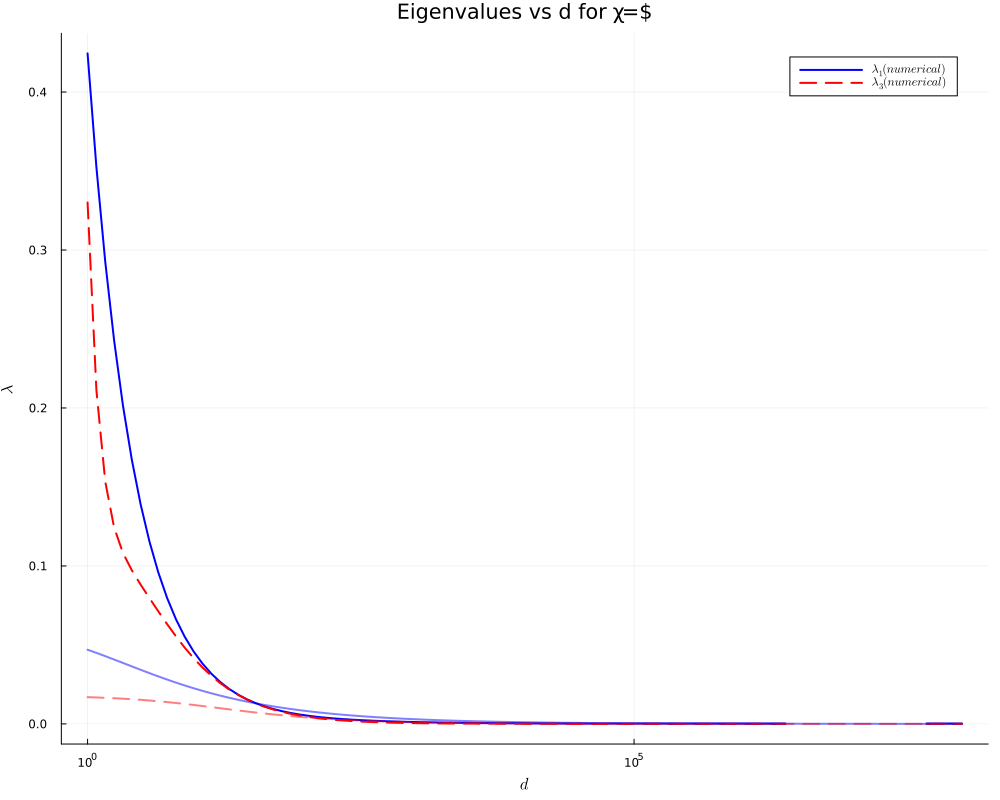

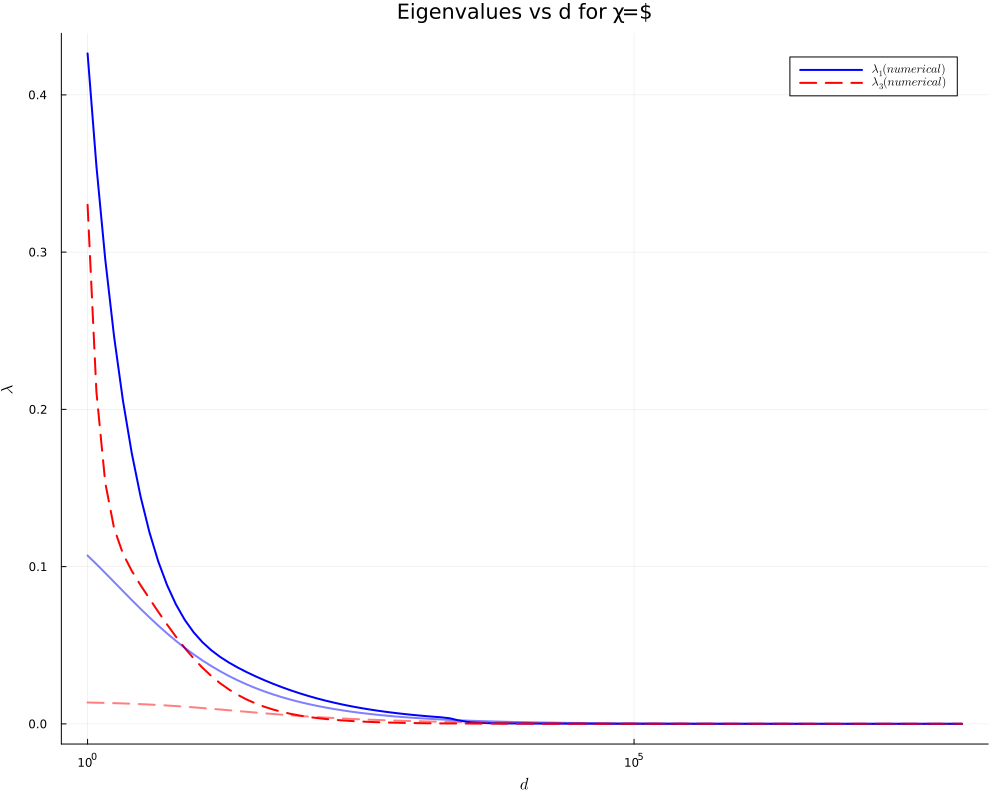

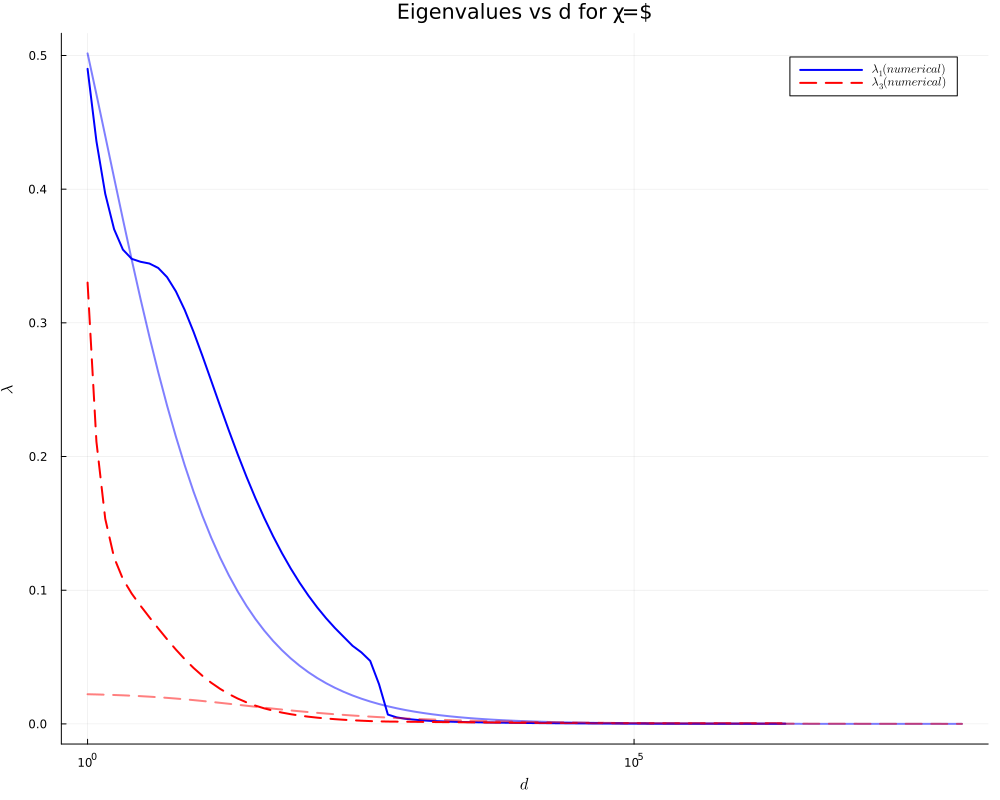

In [7]:
# Parameters
vars_len = 9  # lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT
d = 100  # dimension
n = 1000  # samples
kappa = 1.0
delta = 1.0
epsilon = 0.003
b = 4 / (3 * π)

# Generate P values
alphas = range(0.1, stop=2.0, length=500)
P_values = d .^ collect(alphas)
chi_list = [1.0, n, n^1.5]  # Just solving at χ=1 for now

# ---------------------------
# SYSTEM OF EQUATIONS
# ---------------------------
function equations!(F, x, P, chi)
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = x
    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    
    EChh = lH1 + lH3 +
           (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3

    F[1] = lT1 + chi^2 / (kappa / P + lK1)^2 * delta
    F[2] = lV1 - (lH1 / lJ1^2 - 1 / lJ1)
    F[3] = lH1 - 1 / (1/lJ1 + gammaYh2*lT1/(n*chi))
    F[4] = lJ1 - (4 / (π * (1 + 2*TrSigma)) * lWT)
    
    F[5] = lT3 + chi^2 / (kappa / P + lK3)^2 * delta
    F[6] = lV3 - (lH3 / lJ3^2 - 1 / lJ3)
    F[7] = lH3 - 1 / (1/lJ3 + gammaYh2*lT3*epsilon^2/(n*chi))
    F[8] = lJ3 - (16 / (π * (1 + 2*TrSigma)^3) * (15*lWT^3))
    F[9] = lWT - 1 / (d + delta * b * lV1 / n)
end

# ---------------------------
# HELPER FUNCTIONS
# ---------------------------
compute_lK_ratio(sol, P, dval=d) = begin
    if sol === nothing
        return (NaN, NaN)
    end
    lT1, lV1, lH1, lJ1, lT3, lV3, lH3, lJ3, lWT = sol

    lWP = 1/d
    TrSigma = lWT + lWP*(d-1)
    EChh = lH1 + lH3 +
           (16/ (π * (1 + 2*TrSigma)^3) * (15*lWT^3))*(d-1) +
           (4 / (π * (1 + 2*TrSigma)) * lWT)*(d-1)
    gammaYh2 = (4/π)/(1 + 2*EChh)
    lK1 = gammaYh2*lH1
    lK3 = gammaYh2*lH3
    return (lK1/(lK1 + kappa/P), lK3/(lK3 + kappa/P))
end

is_physical(sol) = all(sol[[3,4,7,8]] .> 0)

# ---------------------------
# SOLVE THE SYSTEM
# ---------------------------
results = Dict{Float64, Vector{Union{Vector{Float64},Nothing}}}()

for chi in chi_list
    println("Solving for chi = $chi ...")
    prev_sol = fill(0.1, vars_len)
    sols = Vector{Union{Vector{Float64},Nothing}}(undef, length(P_values))

    for (i,P) in enumerate(P_values)
        f!(F,x) = equations!(F,x,P,chi)
        try
            sol = nlsolve(f!, prev_sol, ftol=1e-8, method=:newton).zero
            sols[i] = is_physical(sol) ? sol : nothing
            prev_sol = sol  # continuation
        catch
            sols[i] = nothing
        end
    end
    results[chi] = sols
end

# ---------------------------
# POSTPROCESS
# ---------------------------
function extract_series(var_idx)
    Dict(chi => [sol===nothing ? NaN : sol[var_idx] for sol in results[chi]] for chi in chi_list)
end

lH1_series = extract_series(3)
lH3_series = extract_series(7)
lJ1_series = extract_series(4)
lJ3_series = extract_series(8)

lK_ratio = Dict(chi => [compute_lK_ratio(sol, P_values[i]) for (i,sol) in enumerate(results[chi])] for chi in chi_list)

Solving for chi = 1.0 ...


Solving for chi = 1000.0 ...
Solving for chi = 31622.776601683792 ...
Solving for chi = 31622.776601683792 ...


Dict{Float64, Vector{Tuple{Float64, Float64}}} with 3 entries:
  31622.8 => [(0.00596145, 3.08078e-6), (0.00612966, 3.13497e-6), (0.00630559, …
  1000.0  => [(0.00464303, 3.08713e-6), (0.004726, 3.14173e-6), (0.00481048, 3.…
  1.0     => [(0.00460963, 3.08729e-6), (0.0046908, 3.1419e-6), (0.00477338, 3.…

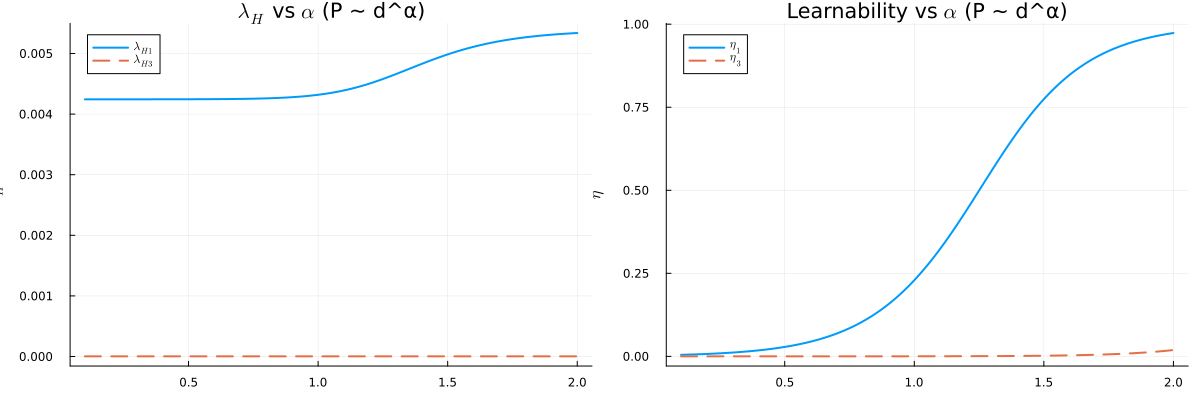

In [8]:
# Plot the results
using Plots
using LaTeXStrings

# Filter valid data points
valid_indices = findall(i -> !isnan(lH1_series[1.0][i]) && !isnan(lH3_series[1.0][i]) && 
                           lH1_series[1.0][i] <= 1.0 && lH3_series[1.0][i] <= 1.0 && 
                           isfinite(lH1_series[1.0][i]) && isfinite(lH3_series[1.0][i]), 
                       1:length(alphas))

# Create plots
p1 = plot(alphas[valid_indices], [lH1_series[1.0][i] for i in valid_indices], 
          label=L"\lambda_{H1}", lw=2,
          xlabel=L"\alpha", ylabel=L"\lambda_H",
          title=L"\lambda_H" * " vs " * L"\alpha" * " (P ~ d^α)")
plot!(alphas[valid_indices], [lH3_series[1.0][i] for i in valid_indices], 
      label=L"\lambda_{H3}", lw=2, linestyle=:dash)

p2 = plot(alphas[valid_indices], [lK_ratio[1.0][i][1] for i in valid_indices], 
          label=L"\eta_1", lw=2,
          xlabel=L"\alpha", ylabel=L"\eta",
          title="Learnability vs " * L"\alpha" * " (P ~ d^α)")
plot!(alphas[valid_indices], [lK_ratio[1.0][i][2] for i in valid_indices], 
      label=L"\eta_3", lw=2, linestyle=:dash)

# Display plots side by side
plot(p1, p2, layout=(1,2), size=(1200,400))

In [9]:
# ---------------------------
# SEPARATE PLOTS PER CHI
# ---------------------------
colors = (:blue, :red)          # λ1: blue, λ3: red
linestyles_num = (:solid, :dash)  # numerical: solid for λ1, dashed for λ3
linestyles_fit = (:solid, :dash)  # fit: same styles, slightly transparent

for chi in chi_list
    λ1 = [r[1] for r in lambda_vals[chi]]
    λ3 = [r[2] for r in lambda_vals[chi]]
    A1, ν1 = fit_params_1[chi]
    A3, ν3 = fit_params_3[chi]

    p = plot(xscale=:log10, xlabel=L"$d$", ylabel=L"\lambda",
             title=L"Eigenvalues vs d for \chi=$(chi)", size=(1000, 800))

    # Plot numerical λ1 and λ3
    plot!(p, d_values, λ1, label=L"\lambda_1 (numerical)", lw=2, ls=linestyles_num[1], color=colors[1])
    plot!(p, d_values, λ3, label=L"\lambda_3 (numerical)", lw=2, ls=linestyles_num[2], color=colors[2])

    # Plot fitted power-law lines (no legend)
    plot!(p, d_values, A1 .* (d_values .+ 1.0)  .^ ν1, label="", lw=2, ls=linestyles_fit[1], color=colors[1], alpha=0.5)
    plot!(p, d_values, A3 .* (d_values .+ 10.0) .^ ν3, label="", lw=2, ls=linestyles_fit[2], color=colors[2], alpha=0.5)

    display(p)
end


LoadError: UndefVarError: `lambda_vals` not defined in `Main`
Suggestion: check for spelling errors or missing imports.